In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from torchvision import datasets, utils
from torchvision.transforms import v2

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from data.image_gaussian import ImageGaussianDistribution

In [3]:
B, C, H, W = 32, 1, 32, 32
 
transform = v2.Compose(
    [v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Resize(size=(H, W))]
)

In [4]:
training_set = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)
training_loader = torch.utils.data.DataLoader(
    training_set, batch_size=B, shuffle=True
)

validation_set = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)
validation_loader = torch.utils.data.DataLoader(
    validation_set, batch_size=B, shuffle=False
)

In [5]:
class EmbeddingMLP(nn.Module):
    def __init__(self, image_channels: int, in_features: int, hidden_features: int):
        super().__init__()
        
        self.image_channels = image_channels
        self.net = nn.Sequential(*[
            nn.Linear(in_features=in_features, out_features=hidden_features),
            nn.SiLU(),
            nn.Linear(in_features=hidden_features, out_features=hidden_features),
            nn.SiLU(),
            nn.Linear(in_features=hidden_features, out_features=image_channels),
        ])
        
    def forward(self, X):
        E = self.net(X)
        return torch.reshape(E, (-1, self.image_channels, 1, 1))

In [6]:
class ResidualLayer(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        super().__init__()
        
        self.time_embed = EmbeddingMLP(image_channels=out_channels, in_features=1, hidden_features=16)
        self.net_in = nn.Sequential(*[
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        ])
        self.net_out = nn.Sequential(*[
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        ])
        
        self.skip = nn.Sequential()
        if in_channels != out_channels:
            self.skip = nn.Sequential(*[
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                nn.BatchNorm2d(out_channels)
            ])
    
    def forward(self, X, T):
        E = self.time_embed(T)

        Z = self.net_in(X)
        Z += E
        Z = self.net_out(Z)
        
        return Z + self.skip(X)

In [7]:
class Downsampler(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int, kernel_size: int):
        super().__init__()
        
        self.net_in = nn.Sequential(*[
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        ])
        
        self.down = nn.MaxPool2d(kernel_size=kernel_size, stride=stride, padding=1)
        
        self.net_out = nn.Sequential(*[
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        ])
    
    def forward(self, X):
        Z = self.net_in(X)
        Z = self.down(Z)
        Z = self.net_out(Z)
        
        return Z

In [8]:
class Upsampler(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, scale: int, kernel_size: int):
        super().__init__()
        
        self.up = nn.Sequential(*[
            nn.Upsample(scale_factor=scale),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        ])
        
        self.net = nn.Sequential(*[
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.SiLU(),
        ])
    
    def forward(self, X):
        Z = self.up(X)
        Z = self.net(Z)
        
        return Z

In [9]:
class UNetEncoder(nn.Module):
    def __init__(self, in_channels: int, stride: int, kernel_size: int):
        super().__init__()
        
        self.residual1 = ResidualLayer(in_channels=in_channels, out_channels=in_channels*2, kernel_size=kernel_size)
        self.residual2 = ResidualLayer(in_channels=in_channels*2, out_channels=in_channels*4, kernel_size=kernel_size)
        self.down = Downsampler(in_channels=in_channels*4, out_channels=in_channels*8, stride=stride, kernel_size=kernel_size)
    
    def forward(self, X, T):
        Z = self.residual1(X, T)
        Z = self.residual2(Z, T)
        return self.down(Z)


class UNetMidcoder(nn.Module):
    def __init__(self, in_channels: int, kernel_size: int):
        super().__init__()
        
        self.residual1 = ResidualLayer(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
        self.residual2 = ResidualLayer(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
        self.residual3 = ResidualLayer(in_channels=in_channels, out_channels=in_channels, kernel_size=kernel_size)
    
    def forward(self, X, T):
        Z = self.residual1(X, T)
        Z = self.residual2(Z, T)
        return self.residual3(Z, T)


class UNetDecoder(nn.Module):
    def __init__(self, in_channels: int, scale: int, kernel_size: int):
        super().__init__()
        
        self.up = Upsampler(in_channels=in_channels, out_channels=in_channels//2, scale=scale, kernel_size=kernel_size)
        self.residual1 = ResidualLayer(in_channels=in_channels//2, out_channels=in_channels//4, kernel_size=kernel_size)
        self.residual2 = ResidualLayer(in_channels=in_channels//4, out_channels=in_channels//8, kernel_size=kernel_size)
    
    def forward(self, X, T):
        Z = self.up(X)
        Z = self.residual1(Z, T)
        return self.residual2(Z, T)

In [10]:
class UNetFlowMatching(nn.Module):
    def __init__(self, in_channels: int, kernel_size: int):
        super().__init__()
        
        self.initial_conv = nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=kernel_size, padding=1)
        
        self.encode1 = UNetEncoder(in_channels=8, stride=2, kernel_size=kernel_size)
        self.encode2 = UNetEncoder(in_channels=64, stride=2, kernel_size=kernel_size)
        
        self.midcoder = UNetMidcoder(in_channels=512, kernel_size=kernel_size)
        
        self.decode1 = UNetDecoder(in_channels=512, scale=2, kernel_size=kernel_size)
        self.decode2 = UNetDecoder(in_channels=64, scale=2, kernel_size=kernel_size)
        
        self.final_conv = nn.Conv2d(in_channels=8, out_channels=1, kernel_size=kernel_size, padding=1)
        self.final_act = nn.Sigmoid()
    
    def forward(self, X, T):
        X = self.initial_conv(X)
        
        E1 = self.encode1(X, T)
        E2 = self.encode2(E1, T)
        
        M1 = self.midcoder(E2, T)
        
        D1 = self.decode1(M1 + E2, T)
        D2 = self.decode2(D1 + E1, T)
        
        return self.final_conv(D2)

In [11]:
def training(
    model: UNetFlowMatching,
    lr: float = 1e-4,
    epochs: int = 10,
    device: str = 'cpu'
):
    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-6)
    gaussian = ImageGaussianDistribution(image_shape=(C, H, W))

    losses = []
    for e in range(epochs):
        model.train()
        training_loss = 0.0
        for i, (Z, _) in enumerate(training_loader):
            T = torch.rand(B).unsqueeze(-1).to(device=device)
            epsilon = gaussian.sample(B, device=device)
            Z = Z.to(device=device)

            X = T.reshape(B, C, 1, 1) * Z + (1 - T).reshape(B, C, 1, 1) * epsilon
            target = Z - epsilon

            out = model(X, T)
            loss = torch.nn.functional.mse_loss(out, target)
            training_loss += loss.item()
            
            if i % 100 == 0:
                print(f"Epoch {e} Batch {i}; : training loss={loss.item():.4f}")

            optimizer.zero_grad()
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

        training_loss /= len(training_loader)
        losses.append(training_loss)
        print(f"Epoch {e}; : training loss={training_loss:.4f}")
        
    return losses

Total Model Parameters: ~21.0mil
Epoch 0 Batch 0; : training loss=2.0940
Epoch 0 Batch 100; : training loss=0.8253
Epoch 0 Batch 200; : training loss=0.6531
Epoch 0 Batch 300; : training loss=0.5688
Epoch 0 Batch 400; : training loss=0.4766
Epoch 0 Batch 500; : training loss=0.4718
Epoch 0 Batch 600; : training loss=0.3946
Epoch 0 Batch 700; : training loss=0.3915
Epoch 0 Batch 800; : training loss=0.3388
Epoch 0 Batch 900; : training loss=0.3167
Epoch 0 Batch 1000; : training loss=0.3075
Epoch 0 Batch 1100; : training loss=0.2874
Epoch 0 Batch 1200; : training loss=0.2894
Epoch 0 Batch 1300; : training loss=0.2615
Epoch 0 Batch 1400; : training loss=0.2401
Epoch 0 Batch 1500; : training loss=0.2512
Epoch 0 Batch 1600; : training loss=0.2201
Epoch 0 Batch 1700; : training loss=0.2113
Epoch 0 Batch 1800; : training loss=0.2127
Epoch 0; : training loss=0.3939
Epoch 1 Batch 0; : training loss=0.2121
Epoch 1 Batch 100; : training loss=0.2129
Epoch 1 Batch 200; : training loss=0.2304
Epoch 

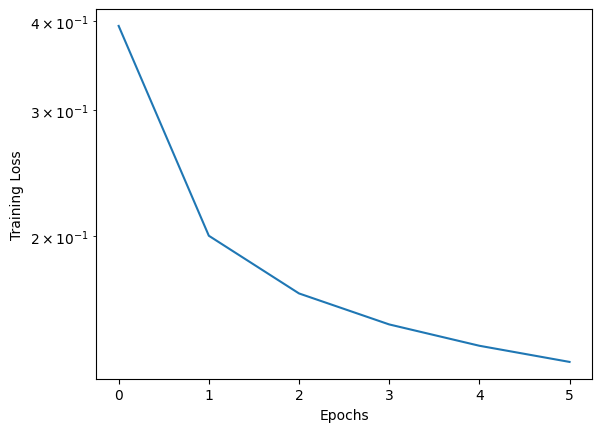

In [12]:
device = 'cuda'

flow_matching = UNetFlowMatching(in_channels=1, kernel_size=3).to(device)
print(f"Total Model Parameters: ~{sum(p.numel() for p in flow_matching.parameters()) // 1e6}mil")

losses = training(model=flow_matching, lr=2e-4, epochs=6, device=device)
fig, ax = plt.subplots()
ax.plot(losses)
ax.set_xlabel('Epochs')
ax.set_ylabel('Training Loss')
ax.set_yscale('log')

fig.show(warn=False)

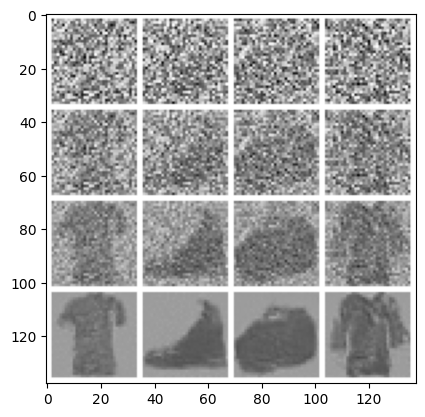

In [13]:
n_steps = 1000
dt = 1/n_steps

X = ImageGaussianDistribution(image_shape=(1, 32, 32)).sample(4, device='cuda')

flow_matching.eval()
images = []
with torch.no_grad():
    for i in range(n_steps):
        T = torch.ones(4, 1, device=device) * (i * dt)
        U = flow_matching(X, T)
        
        X = X + dt * U
        
        if (i+1) % (n_steps//4) == 0:
            out = torch.sigmoid(X.detach().cpu())
            images.append(out)

npimg = utils.make_grid(tensor=torch.cat(images, dim=0), nrow=4, normalize=True)
plt.imshow(npimg[0].numpy(), cmap="Greys")

In [14]:
torch.save(flow_matching.state_dict(), f'outputs/fashion_flow_model_v{0}.pt')